# Getting started with Task 3

Download the dataset from the [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106) using the script `download_intracardiac_dataset.sh`:

```bash
source download_intracardiac_dataset.sh
```

## Load Modules and Preprocessing Functions

Load modules and preprocessing functions.

In [35]:
import re, os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Load the `cardiac_ml_tools` module.

In [36]:
%run 'cardiac_ml_tools.py'

## Load the dataset

In [733]:
data_dirs = []
regex = r'data_hearts_dd_0p2*'
DIR='intracardiac_dataset/' # This should be the path to the intracardiac_dataset, it can be downloaded using data_science_challenge_2023/download_intracardiac_dataset.sh
for x in os.listdir(DIR):
    if re.match(regex, x):
        data_dirs.append(DIR + x)
file_pairs = read_data_dirs(data_dirs)
print('Number of file pairs: {}'.format(len(file_pairs)))
# example of file pair
print("Example of file pair:")
print("{}\n{}".format(file_pairs[0][0], file_pairs[0][1]))


Number of file pairs: 16117
Example of file pair:
intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy
intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/VmData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.000.pattern.0.volunteer.v12.npy


## Dataset details

The dataset [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106)
consists of pairs of computationally simulated intracardiac transmembrane voltage recordings and ECG signals.
In total, 16140 organ-level simulations were conducted to create this dataset.
Simulations were performed using Lassen supercomputer at Lawrence Livermore National Lab (LLNL), concurrently utilizing 4 GPUs and 40 CPU cores.
Each simulation produced pairs of 500ms-by-10 raw electrode signals and 500ms-by-75 transmembrane voltage signals.
For convenience, we collect those signals in matrices and give them the following names:

Tensor | Description | Shape | Notes
--- | --- | --- | ---
$X$ | Row electrode signals | $10 \times 500$ | 10-lead ECG signals from the simulated torso (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$V$ | Activation map | $75 \times 500$ | Transmembrane voltage signals from the simulated heart (in [Dataset of Simulated Intracardiac Transmembrane Voltage Recordings and ECG Signals](https://library.ucsd.edu/dc/object/bb29449106))
$E$ | 12-lead ECG signals | $12 \times 500$ | 12-lead ECG signals obtained by `get_standard_leads`($X$)
$A$ | Activation map | $75 \times 1$ | Activation time, defined as $A_i = \text{min}_j(V_{ij})$

**IMPORTANT** : The raw data in the dataset consists of 10-lead ECG signals and 75-lead transmembrane voltage signals. The 12-lead ECG signals are obtained from the 10-lead ECG signals using the function `get_standard_leads` (in the file `cardiac_ml_tools.py`).

The overall generation process is shown in the following image. The ECG signal is recorded using 10 virtual electrodes and the transmembrane voltages are recorded at 75 points within the myocardium. The transmembrane voltages are then used to generate the spatio-temporal activation maps.

![ECG 10 2 12](https://github.com/Noah-Gallego/cardiac_challenge/blob/main/figures/data_generation.png?raw=1)

## Getting the standard 12-lead ECG from the 10-lead ECG

The function `get_standard_leads` (in the file `cardiac_ml_tools.py`) is used to obtain the 12-lead ECG signals from the 10-lead ECG signals. It implements the following transformation, where the (Wilson Lead) is defined as $Vw = 1/3*(RA + LA + LL)$:
$$
\left\{
\begin{array}{lll}
    X_{:,1}  & \to  & RA \\
    X_{:,2}  & \to  & LA \\
    X_{:,3}  & \to  & LL \\
    X_{:,4}  & \to  & RL \\
    X_{:,5}  & \to  & V1 \\
    X_{:,6}  & \to  & V2 \\
    X_{:,7}  & \to  & V3 \\
    X_{:,8}  & \to  & V4 \\
    X_{:,9}  & \to  & V5 \\
    X_{:,10} & \to &  V6 \\
\end{array}
\right.
\text{        and        }
\left\{
\begin{array}{lll}          
\text{Lead } I& : & LA - RA \\
\text{Lead } II& : & LL - RA \\
\text{Lead } III& : & LL - LA \\
\text{Lead } aVR& : &  \frac{3}{2} (RA - Vw) \\
\text{Lead } aVL& : &  \frac{3}{2} (LA - Vw) \\
\text{Lead } aVF& : &  \frac{3}{2} (LL - Vw)\\
\text{Lead } V1 & : & V1 - Vw \\
\text{Lead } V2 & : & V2 - Vw \\
\text{Lead } V3 & : & V3 - Vw \\
\text{Lead } V4 & : & V4 - Vw \\
\text{Lead } V5 & : & V5 - Vw \\
\text{Lead } V6 & : & V6 - Vw \\
\end{array}
\right.
$$

In [734]:
def normalize_data(data):
  # Max-Min Normalization
  data = (data - np.min(data)) / (np.max(data) - np.min(data))
  return data


n = len(file_pairs)
ecg_data_arr = np.zeros((n,12,500))
act_time_data_arr = np.zeros((n,75))
for i in tqdm(range(n)):
    pECGData = np.load(file_pairs[i][0])
    pECGData = get_standard_leads(pECGData)
    temp = pECGData.T
    for j in range(12):
        temp2 = temp[j,:]
        temp2 = normalize_data(temp2)
        ecg_data_arr[i,j,:] = temp2
    VmData = np.load(file_pairs[i][1])
    ActTime = get_activation_time(VmData)
    ActTime = ActTime.T
    for j in range(75):
        act_time_data_arr[i,j] = ActTime[0,j]

100%|██████████| 16117/16117 [00:48<00:00, 335.02it/s]


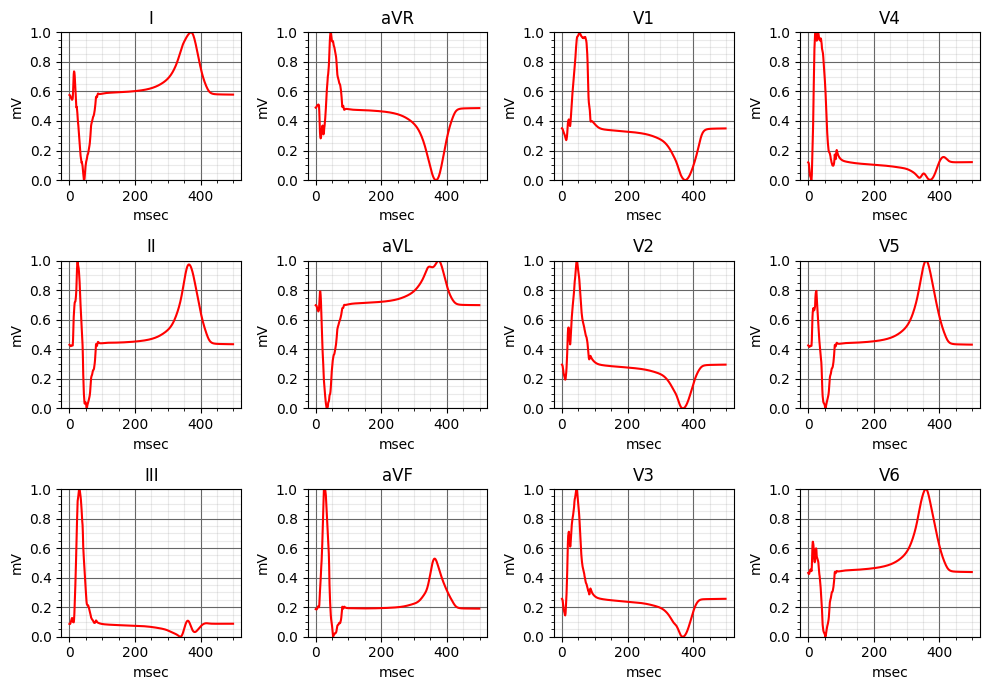

In [735]:
# Example of file pair
case = 213
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1: 1, 2: 5, 3: 9, 4: 2, 5: 6, 6: 10, 7: 3, 8: 7, 9: 11, 10: 4, 11: 8, 12: 12} # reorder the leads to standard 12-lead ECG display

pECGData = np.load(file_pairs[213][0])
pECGData = get_standard_leads(pECGData)
pECGData = pECGData.T

for i in range(pECGData.shape[0]):
    temp = normalize_data(pECGData[i, :])
    ax = plt.subplot(row, column, reorder[i + 1])
    ax.plot(temp, 'r')
    ax.set_title(titles[i])
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.set_xlabel('msec')
    ax.set_ylabel('mV')
    ax.set_ylim([0, 1])  # Set the y-axis limits for each subplot

plt.tight_layout()
plt.show()

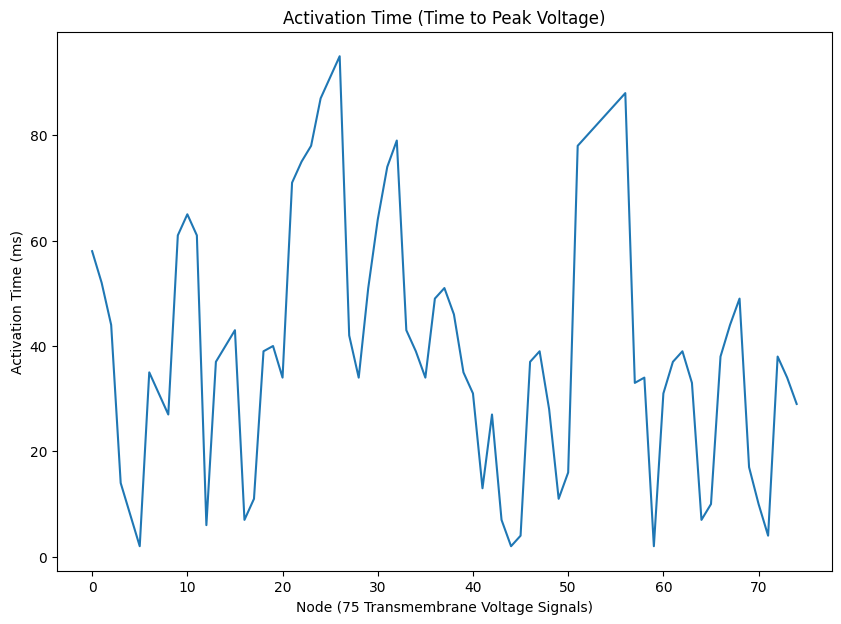

'\n    - We are plotting the activation time for a random heart. High Voltage = Early Activation, Low Voltage = Late Activation\n    - 75 Represents the number of nodes or transmembrane voltage signals in the heart. \n    - Each node represents a different location in the heart. \n    - The activation time represents the time it takes for the electrical signal to travel from the sinoatrial node to the different parts of the heart. \n    - The activation time is measured in milliseconds (ms). \n    - The activation time is important for understanding the electrical activity of the heart and diagnosing arrhythmias. \n    - In this case, the activation time is calculated as the time to peak voltage for each node. \n    - The activation time is used to identify the sequence of activation of the different parts of the heart.\n'

In [736]:
# Plot Activation Time
plt.figure(figsize=(10, 7))
plt.plot(ActTime_np[np.random.randn(ActTime_np.shape[0]).argsort()[:1]].T)
plt.title('Activation Time (Time to Peak Voltage)')
plt.xlabel('Node (75 Transmembrane Voltage Signals)')
plt.ylabel('Activation Time (ms)')
plt.show()

'''
    - We are plotting the activation time for a random heart. High Voltage = Early Activation, Low Voltage = Late Activation
    - 75 Represents the number of nodes or transmembrane voltage signals in the heart. 
    - Each node represents a different location in the heart. 
    - The activation time represents the time it takes for the electrical signal to travel from the sinoatrial node to the different parts of the heart. 
    - The activation time is measured in milliseconds (ms). 
    - The activation time is important for understanding the electrical activity of the heart and diagnosing arrhythmias. 
    - In this case, the activation time is calculated as the time to peak voltage for each node. 
    - The activation time is used to identify the sequence of activation of the different parts of the heart.
'''

In [737]:
from sklearn.model_selection import train_test_split

In [738]:
# Split in Train and Test
X = ecg_data_arr
y = act_time_data_arr
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("X TRAIN: ", X_train.shape)
print("y TRAIN: ", y_train.shape)
print("X TEST: ", X_test.shape)
print("y TEST: ", y_test.shape)

X TRAIN:  (12893, 12, 500)
y TRAIN:  (12893, 75)
X TEST:  (3224, 12, 500)
y TEST:  (3224, 75)


(12, 500)


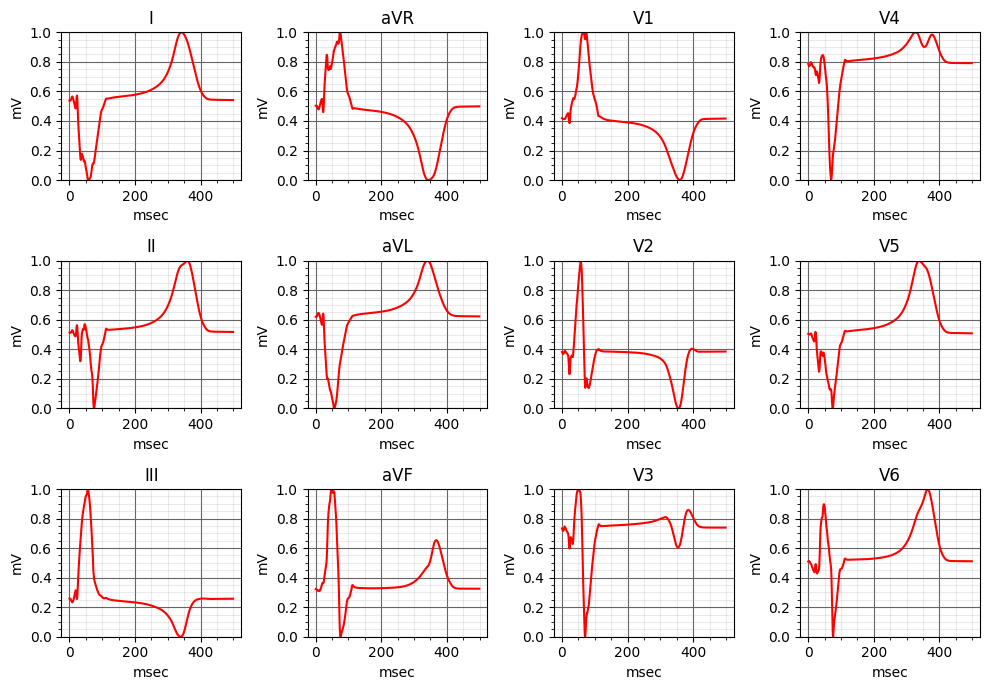

In [739]:
import matplotlib.pyplot as plt

# Example of file pair
case = 0
# ECG plot
row = 3
column = 4
num_timesteps = 500
plt.figure(figsize=(10, 7))
titles = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
reorder = {1: 1, 2: 5, 3: 9, 4: 2, 5: 6, 6: 10, 7: 3, 8: 7, 9: 11, 10: 4, 11: 8, 12: 12} # reorder the leads to standard 12-lead ECG display

# Get ECG Data at index case
pECGData = X_train[case]
print(pECGData.shape)
# create a figure with 12 subplots
for i in range(pECGData.shape[0]):
    ax = plt.subplot(row, column, reorder[i + 1])
    ax.plot(pECGData[i,0:num_timesteps], 'r')    
    ax.set_title(titles[i])
    ax.grid(visible=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    ax.set_xlabel('msec')
    ax.set_ylabel('mV')
    ax.set_ylim([0, 1])  # Set the y-axis limits for each subplot

plt.tight_layout()
plt.show()

## Getting the activation map from the transmembrane voltages

The funtion `get_activation_map` (in the file `cardiac_ml_tools.py`) is used to obtain the activation map from the transmembrane voltages. It implements the following transformation $A_i = \text{min}_j(V_{ij})$.

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


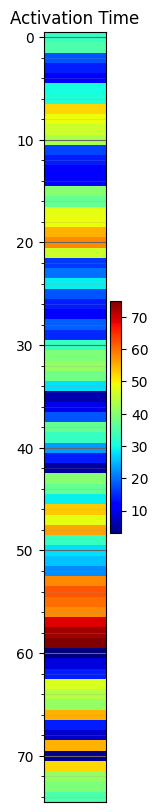

In [741]:
# Example of file pair
case = 213
plt.figure(figsize=(1, 10))

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = X_train[case]

# plot the Activation Time array
plt.imshow(ActTime.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('Activation Time')
plt.colorbar()
plt.grid(visible=True, which='major', color='#666666', linestyle='-')
plt.minorticks_on()
# not xticks
plt.xticks([])
plt.grid(visible=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
plt.show()
plt.close()

## Task 3: Learning the mapping from the 12-lead ECG to the activation map

Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy
Case 213 : intracardiac_dataset/data_hearts_dd_0p2_geo_act_1_bcl_gkr/pECGData_hearts_dd_0p2_geo_act_1_bcl_gkr_bcl.1000.gkr.050.pattern.11.volunteer.v9.npy


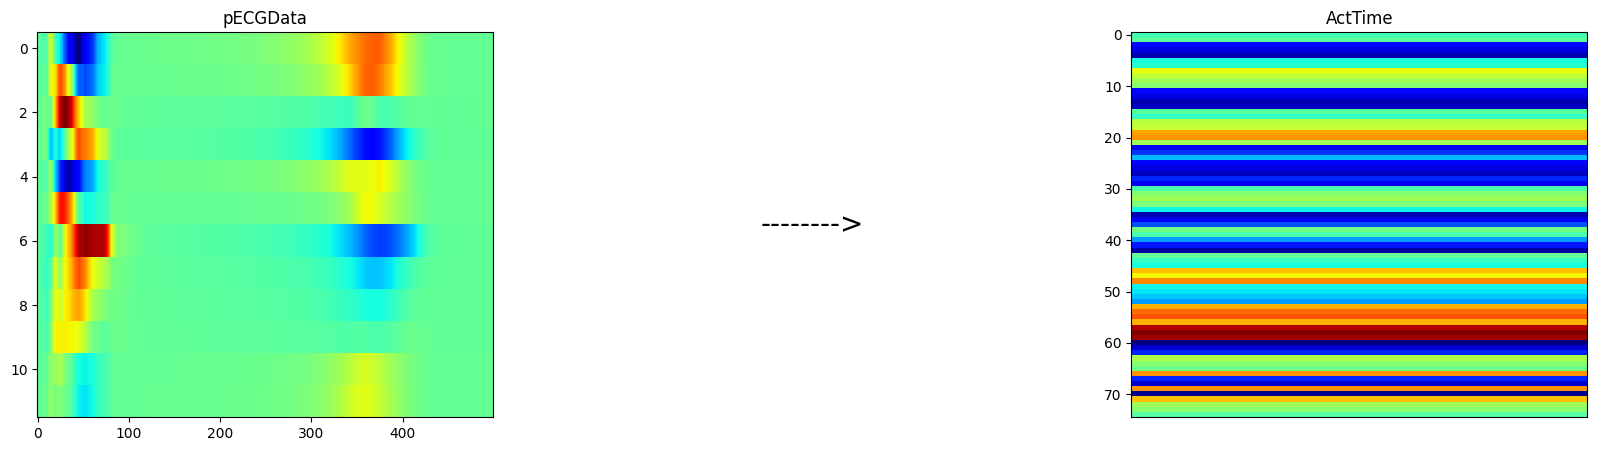

In [742]:
# make a plot with the "pECGData" -> "ActTime"
case = 213

print('Case {} : {}'.format(case, file_pairs[case][0]))
pECGData = np.load(file_pairs[case][0])
pECGData = get_standard_leads(pECGData)

print('Case {} : {}'.format(case, file_pairs[case][0]))
VmData = np.load(file_pairs[case][1])
ActTime = get_activation_time(VmData)

# plot in row the tensors pECGData and ActTime with an arrow pointing to the activation time
row = 1
column = 3
plt.figure(figsize=(20, 5))
plt.subplot(row, column, 1)
# plot pECGData transposed
plt.imshow(pECGData.T, cmap='jet', interpolation='nearest', aspect='auto')
plt.title('pECGData')
plt.subplot(row, column, 2)
# print an arrow
plt.text(0.5, 0.5, '-------->', horizontalalignment='center', verticalalignment='center', fontsize=20)
plt.axis('off')
plt.subplot(row, column, 3)
# plot ActTime
plt.imshow(ActTime, cmap='jet', interpolation='nearest', aspect='auto')
# not xticks
plt.xticks([])
plt.title('ActTime')
plt.show()
plt.close()

# Tricks

- As in many machine learning problems, normalization of the data might be helpful or even necessary. Different normalization schemes might be applied.

In [794]:
# Import Packages for 1D CNN Model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, LSTM, Concatenate, Dropout, Input, GlobalAveragePooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

In [795]:
def fire_module(x, squeeze_filters, expand1x1_filters, expand3x3_filters):
    squeeze = Conv1D(squeeze_filters, kernel_size=1, strides=1, activation = 'relu', padding='same')(x)   
    expand1x1 = Conv1D(expand1x1_filters, kernel_size=1, strides=1, activation = 'relu', padding='same')(squeeze)    
    expand3x3 = Conv1D(expand3x3_filters, kernel_size=3, strides=1, activation = 'relu', padding='same')(squeeze)  
    return Concatenate()([expand1x1, expand3x3])

In [819]:
def HybridModel(num_classes, input_shape, version):
    if version == 1:
        # Mix of CNN and LSTM
        input = Input(shape = input_shape)

        x = Conv1D(64, kernel_size = 3, padding = 'same', activation = 'relu')(input)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization()(x)
        
        x = Conv1D(128, kernel_size=3, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization()(x)
        
        x = Conv1D(256, kernel_size=3, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = BatchNormalization()(x)

        x = Conv1D(512, kernel_size=3, padding='same', activation='relu')(x)
        x = MaxPooling1D(pool_size=1)(x)
        x = BatchNormalization()(x)
        
        x = LSTM(128, return_sequences=True)(x)
        x = LSTM(64, return_sequences=False)(x)
        
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.2)(x)
        
        # Output Dense Layers
        output = Dense(num_classes, activation='linear')(x)
        
        model = Model(inputs=input, outputs=output)
        return model
    else:
        # SqueezeNet
        input = Input(shape=input_shape)
        x = Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu')(input)
        x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
        x = fire_module(x, 16, 64, 64)
        x = fire_module(x, 16, 64, 64)

        x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
        x = fire_module(x, 32, 128, 128)
        x = fire_module(x, 32, 128, 128)

        x = MaxPooling1D(pool_size=3, strides=2, padding='same')(x)
        x = fire_module(x, 48, 192, 192)
        x = fire_module(x, 48, 192, 192)
        x = fire_module(x, 64, 256, 256)
        x = fire_module(x, 64, 256, 256)

        x = Conv1D(512, kernel_size=3, strides=1, padding='same', activation='relu')(x)
        x = fire_module(x, 80, 320, 320)
        x = fire_module(x, 80, 320, 320)
        x = fire_module(x, 80, 320, 320)
        x = fire_module(x, 80, 320, 320)
        x = fire_module(x, 96, 384, 384)
        x = fire_module(x, 96, 384, 384)
        x = fire_module(x, 96, 384, 384)
        x = fire_module(x, 96, 384, 384)
        x = GlobalAveragePooling1D()(x)
        
        x = Dense(256, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(0.4)(x)
        x = Dense(128, activation='relu', kernel_regularizer='l2')(x)
        x = Dropout(0.3)(x)

        output = Dense(num_classes, activation='linear')(x)

        model = Model(inputs=input, outputs=output)
        return model

Epoch 1/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 1521.4835 - mean_squared_error: 1521.4835 - val_loss: 752.6669 - val_mean_squared_error: 752.6669
Epoch 2/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 530.6645 - mean_squared_error: 530.6645 - val_loss: 439.7526 - val_mean_squared_error: 439.7526
Epoch 3/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 469.7543 - mean_squared_error: 469.7543 - val_loss: 423.6560 - val_mean_squared_error: 423.6560
Epoch 4/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 451.4540 - mean_squared_error: 451.4540 - val_loss: 619.7156 - val_mean_squared_error: 619.7156
Epoch 5/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 401.4747 - mean_squared_error: 401.4747 - val_loss: 334.4659 - val_mean_squared_error: 334.4659
Epoch 6/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 354.3770 - mean_squared_error: 354.3770 - val_loss: 303.8647 - val_mean_squared_error: 303.8647
Epoch 7/1000
403/403 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/s

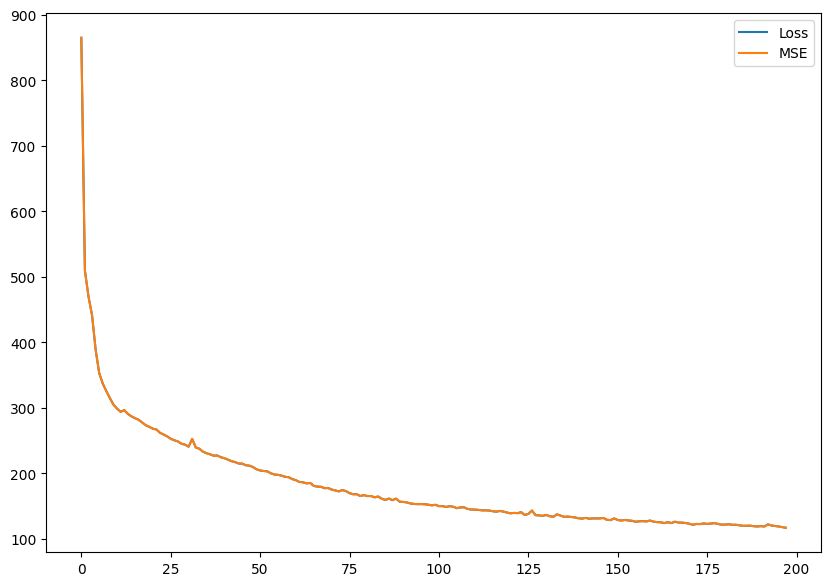

In [820]:
# Train Model
version = input("Enter '1' for Hybrid, '2' for AdvancedSqueezeNet1D: ")
input_shape = (12, 500)
num_classes = y_train.shape[1]
model = HybridModel(num_classes, input_shape, version)
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True)

# Adjust LR
optimize = Adam(learning_rate=0.001)
model.compile(optimizer = optimize, loss = 'mean_squared_error', metrics = ['mean_squared_error'])

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['mean_squared_error'])
history = model.fit(X_train, y_train, batch_size = 32, epochs = 1000, validation_data = (X_test, y_test), callbacks=[early_stopping])

# Plot the Model's Loss / MSE
plt.figure(figsize = (10, 7))
plt.plot(model.history.history['loss'], label = 'Loss')
plt.plot(model.history.history['mean_squared_error'], label = 'MSE')
print(model.history.history.keys())
plt.legend()
plt.show()

In [821]:
print(model.history.history.keys())

dict_keys(['loss', 'mean_squared_error', 'val_loss', 'val_mean_squared_error'])


101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
   Actual  Predicted
0    49.0  53.013554
1    45.0  50.608864
2    40.0  52.607128
3    65.0  53.577374
4    70.0  66.739380
5    74.0  64.615128
6    40.0  47.475605
7    42.0  40.656609
8    45.0  43.370140
9    80.0  74.020782


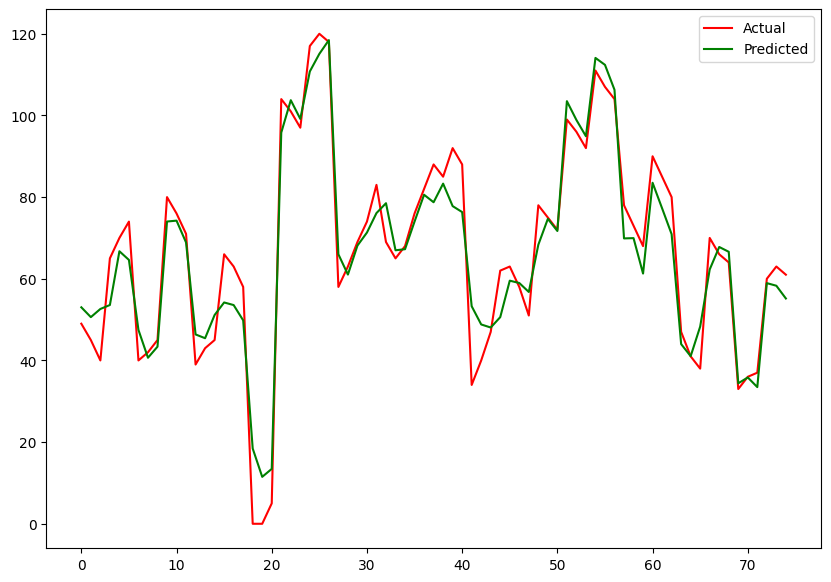

On average, our prediction lies within 5.93 ms of the actual activation time.


In [823]:
predictions = model.predict(X_test)

comparison = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': predictions.flatten()})
print(comparison.head(10))

# Visualize the Predictions
plt.figure(figsize=(10, 7))
plt.plot(y_test[0], label = 'Actual', color = 'r')
plt.plot(predictions[0], label = 'Predicted', color = 'g')
plt.legend()
plt.show()

difference = round(np.mean(np.abs(y_test - predictions)), 2)

print('On average, our prediction lies within {} ms of the actual activation time.'.format(difference))
